In [1]:
import MY_utils
import opt
import time

from scipy.sparse import kron, kronsum, eye

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from os import cpu_count
# %matplotlib qt

N_CPUS =  cpu_count()

RESULTS_PATH = 'results/efficient_alg/' 

## Filter ID step

### GF ID step

The efficient filter ID step performs N^3 operations at each iteration (no indexing is involved).

In [2]:
NN = [10, 25, 50, 100]
list_iters = [50, 150]
M = 500
p_er = 0.15
noise = 0.01
eps = 0
K = 4
gamma = .1  # .5
mu = .01

times = np.zeros((len(list_iters)+1, len(NN)))
err = np.zeros((len(list_iters)+1, len(NN)))
for i, N in enumerate(NN):
    print('N:', N)
    X, Y, _, _, H, S, _, _ = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    norm_H = np.linalg.norm(H,'fro')
    h = H.flatten('F')

    # Efficient grad
    for j, iters in enumerate(list_iters):
        t = time.time()
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')

        h_init = np.zeros(N**2)

        H_hat, h_iters = opt.efficient_filter_id(XX, S, y_kron, gamma, mu, h_init, eps=1e-3, max_iters=iters, verbose=False)
        times[j,i] = time.time() - t

        err[j,i] = np.linalg.norm(H_hat - H, 'fro')**2/norm_H**2
        print(f'\t- Efficient (iters={iters}): time: {times[j, i]:.3f}s  - err: {err[j,i]:.3f}')

    # Inverse step
    t = time.time()
    X_kron = np.kron(XX, np.eye(N))
    y_kron = np.kron(X, np.eye(N))@Y.flatten(order='F')
    Z = np.kron(S@S, np.eye(N)) + np.kron(np.eye(N), S@S) - 2*np.kron(S, S)
    H_inv = (np.linalg.inv(X_kron + gamma*Z)@y_kron).reshape((N,N), order='F')
    times[-1, i] = time.time() - t

    err[-1,i] = np.linalg.norm(H_inv - H, 'fro')/norm_H
    print(f'\t- Inverse: time: {times[-1, i]:.3f}s  - err: {err[-1,i]:.3f}')


N: 10
	- Efficient (iters=50): time: 0.007s  - err: 0.000
	- Efficient (iters=150): time: 0.005s  - err: 0.000
	- Inverse: time: 0.007s  - err: 0.013
N: 25
	- Efficient (iters=50): time: 0.048s  - err: 0.000
	- Efficient (iters=150): time: 0.042s  - err: 0.000
	- Inverse: time: 0.132s  - err: 0.022
N: 50
	- Efficient (iters=50): time: 0.349s  - err: 0.001
	- Efficient (iters=150): time: 0.380s  - err: 0.001
	- Inverse: time: 1.554s  - err: 0.030
N: 100
	- Efficient (iters=50): time: 4.705s  - err: 0.009
	- Efficient (iters=150): time: 4.401s  - err: 0.002
	- Inverse: time: 40.428s  - err: 0.036


Text(0, 0.5, 'norm(h-h_hat)/norm(h)')

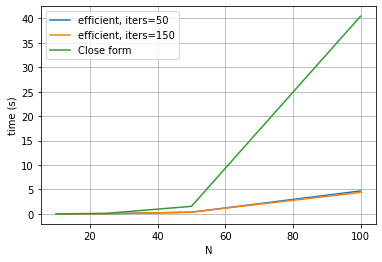

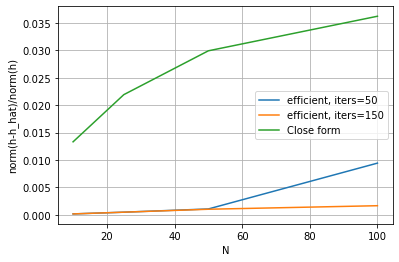

In [3]:
leg = [f'efficient, iters={iters}' for iters in list_iters] + ['Close form']

# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')
# plt.savefig(RESULTS_PATH + 'filter_id_time.pdf')

# Plot error
plt.figure()
plt.plot(NN, err.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(h-h_hat)/norm(h)')
# plt.savefig(RESULTS_PATH + 'filter_id_err.pdf')


<ipython-input-4-19df72ceb417>:6: RuntimeWarning: invalid value encountered in double_scalars
  dist_hs[i] = np.linalg.norm(h_iters[i+1,:] - h_iters[i,:])/np.linalg.norm(h_iters[i,:])


Last err: [0.0133155  0.02191002 0.02990094 0.03620004]


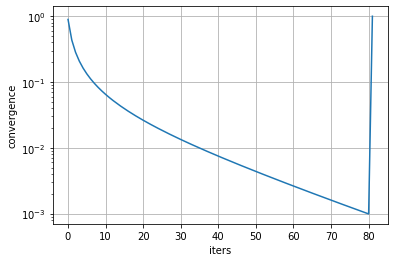

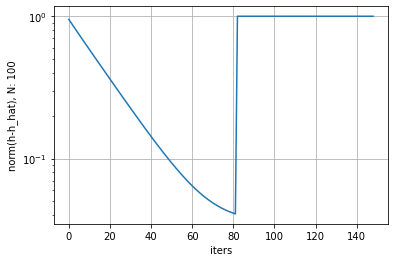

In [4]:
## Compute convergence
dist_hs = np.zeros(h_iters.shape[0]-1)
err_conv = np.zeros(h_iters.shape[0]-1)
norm_h = np.linalg.norm(h)
for i in range(h_iters.shape[0]-1):
    dist_hs[i] = np.linalg.norm(h_iters[i+1,:] - h_iters[i,:])/np.linalg.norm(h_iters[i,:])
    err_conv[i] = np.linalg.norm(h - h_iters[i,:])/norm_h


print('Last err:', err[-1])

plt.figure()
plt.semilogy(dist_hs)
plt.xlabel('iters')
plt.ylabel('convergence')
plt.grid()

plt.figure()
plt.semilogy(err_conv)
plt.xlabel('iters')
plt.ylabel('norm(h-h_hat), N: ' + str(N))
plt.grid()

### Convergence for different values of gamma

In [5]:
NN = [50, 100, 150]
iters = 500
M = 500
p_er = 0.15
noise = 0.01
eps = 0
K = 4
GAMMAS = [.01, .1, .2]
mu = .01

Hs_hat = []
hs = []
for i, N in enumerate(NN):
    print('N:', N)
    Hs_hat.append(np.zeros((len(GAMMAS), iters, N**2)))
    X, Y, _, _, H, S, _, _ = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    norm_H = np.linalg.norm(H,'fro')
    h = H.flatten('F')

    hs.append(h)

    # Efficient grad
    for j, gamma in enumerate(GAMMAS):
        t = time.time()
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')
        h_init = np.zeros(N**2)

        H_hat, h_iters = opt.efficient_filter_id(XX, S, y_kron, gamma, mu, h_init, eps=1e-3, max_iters=iters, verbose=False)
        t_end = time.time() - t

        err = np.linalg.norm(H_hat - H, 'fro')**2/norm_H**2
        Hs_hat[i][j,:,:] = h_iters
        
        print(f'\t- Efficient (iters={iters}): time: {t_end:.3f}s  - err: {err:.3f}')


N: 50
	- Efficient (iters=500): time: 0.240s  - err: 0.001
	- Efficient (iters=500): time: 0.221s  - err: 0.001
	- Efficient (iters=500): time: 0.208s  - err: 0.001
N: 100
	- Efficient (iters=500): time: 4.003s  - err: 0.003
	- Efficient (iters=500): time: 3.418s  - err: 0.002
	- Efficient (iters=500): time: 3.391s  - err: 0.001
N: 150
	- Efficient (iters=500): time: 15.857s  - err: 0.004
	- Efficient (iters=500): time: 14.298s  - err: 0.002
	- Efficient (iters=500): time: 62.242s  - err: 0.379


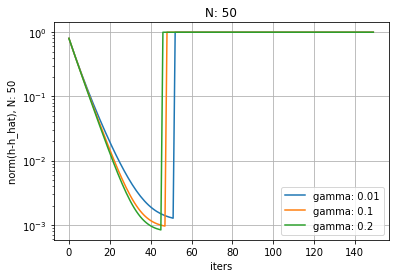

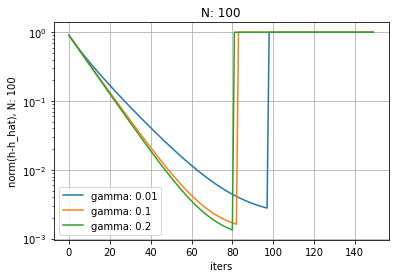

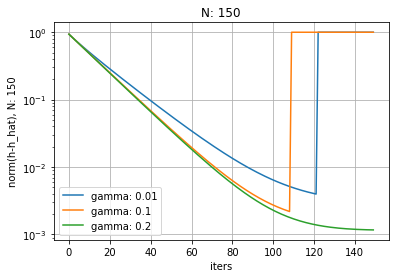

In [6]:
## Compute convergence
err_conv = np.zeros((len(NN), len(GAMMAS), iters-1))
for i in range(len(NN)):
    h = hs[i]
    norm_h = np.linalg.norm(h)**2
    h_iters = Hs_hat[i]
    for j in range(len(GAMMAS)):
        for k in range(iters-1):
            err = np.linalg.norm(h - h_iters[j,k,:])**2/norm_h
            err_conv[i,j,k] = err if err < 1 else 1

leg = []
for N in NN:
    for gamma in GAMMAS:
        leg.append(f'N: {N}, gamma: {gamma}')

plot_iters = 150
for i, N in enumerate(NN):
    leg = [f'gamma: {gamma}' for gamma in GAMMAS]
    plt.figure()

    plt.semilogy(err_conv[i,:,:plot_iters].T)
    plt.xlabel('iters')
    plt.ylabel('norm(h-h_hat), N: ' + str(N))
    plt.legend(leg)
    plt.title(f'N: {N}')
    plt.grid()

## Efficiency of the graph denoising step

### Graph denoising step

The graph denoising step updates each of the N^2 enties of S at ever iteration.
Each update of s[i] involves N operations but we need to index a vector of size N^2.

In [7]:
NN = [10, 25, 50, 75, 100] # 50]
list_iters = [50, 150]
M = 500
p_er = 0.15
noise = 0.05
eps = .05
K = 4
lamb = .1  # .1
beta = .01 # .01
gamma = .1

times = np.zeros((len(list_iters)+1, len(NN)))
err = np.zeros((len(list_iters)+1, len(NN)))
Ss = []
Ss_hat = []
for i, N in enumerate(NN):
    print('N:', N)
    _, _, _, _, H, S, Sn, h = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    Ss.append(S)
    norm_S = np.linalg.norm(S, 'fro')

    low_idx = np.concatenate([np.arange(i+1, N)+N*i for i in range(N)])
    s = S.flatten('F')[low_idx]
    sn = Sn.flatten('F')[low_idx]

    Ss_hat.append(np.zeros((len(list_iters), N, N)))

    # Efficient grad
    for j, iters in enumerate(list_iters):
        t = time.time()
        S_hat, s_iters = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters, verbose=False)
        times[j,i] = time.time() - t
        Ss_hat[i][j,:,:] = S_hat 

        err[j,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        err_b = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2

        print(f'\t- Efficient (iters={iters}): time: {times[j, i]:.3f}s  - err (scale free): {err[j,i]:.3f} - err: {err_b:.3f}')


    # CVX step
    t = time.time()
    S_cvx = opt.graph_id(Sn, H, np.eye(N), lamb, gamma, delta=0)
    times[-1, i] = time.time() - t

    err[-1,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2
    err_b = np.linalg.norm(S_cvx - S, 'fro')**2/norm_S**2
    print(f'\t- CVX: time: {times[-1, i]:.3f}s  - err: {err[-1,i]:.3f} - err B: {err_b:.3f}')

N: 10
	- Efficient (iters=50): time: 0.219s  - err (scale free): 0.006 - err: 0.006
	- Efficient (iters=150): time: 0.167s  - err (scale free): 0.006 - err: 0.006
	- CVX: time: 0.019s  - err: 0.003 - err B: 0.003
N: 25
	- Efficient (iters=50): time: 3.195s  - err (scale free): 0.041 - err: 0.857
	- Efficient (iters=150): time: 9.388s  - err (scale free): 0.006 - err: 0.593
	- CVX: time: 0.943s  - err: 0.000 - err B: 0.000
N: 50
	- Efficient (iters=50): time: 12.974s  - err (scale free): 0.119 - err: 0.979
	- Efficient (iters=150): time: 39.542s  - err (scale free): 0.051 - err: 0.929
	- CVX: time: 66.076s  - err: 0.000 - err B: 0.000
N: 75
	- Efficient (iters=50): time: 30.278s  - err (scale free): 0.453 - err: 0.998
	- Efficient (iters=150): time: 87.121s  - err (scale free): 0.253 - err: 0.995
	- CVX: time: 211.692s  - err: 0.000 - err B: 0.000
N: 100
	- Efficient (iters=50): time: 50.814s  - err (scale free): 0.495 - err: 0.994
	- Efficient (iters=150): time: 153.477s  - err (scale 

### Show estimated graphs

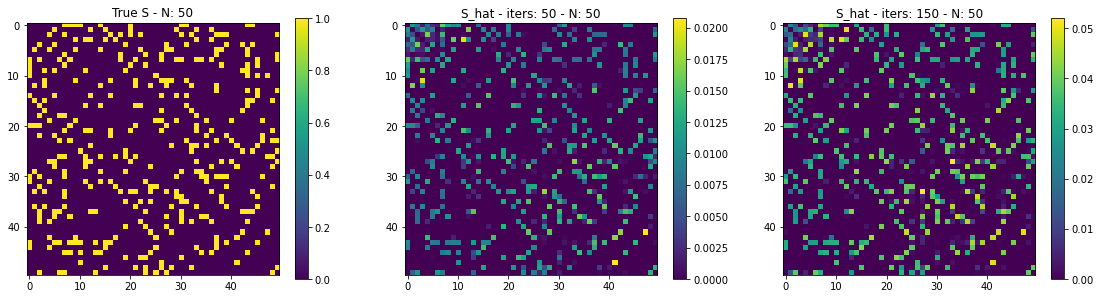

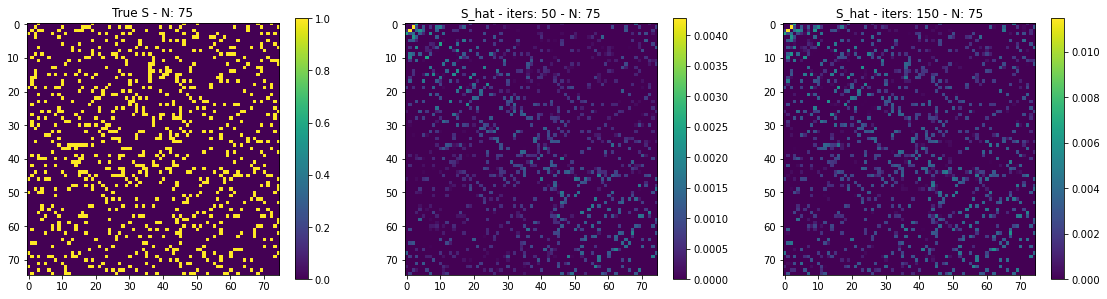

In [8]:
show_sizes = [50, 75]

for i, N in enumerate(NN):
    if N not in show_sizes:
        continue

    plt.figure(figsize=(19.2, 4.8))
    plt.subplot(1, len(list_iters)+1, 1)
    plt.imshow(Ss[i])
    plt.colorbar()
    plt.title(f'True S - N: {N}')

    for j in range(len(list_iters)):
        plt.subplot(1, len(list_iters)+1, j+2)
        plt.imshow(Ss_hat[i][j,:,:])
        plt.colorbar()
        plt.title(f'S_hat - iters: {list_iters[j]} - N: {N}')


Text(0, 0.5, 'norm(s-s_hat)')

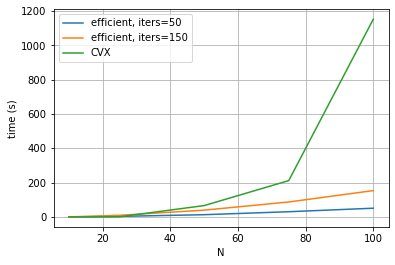

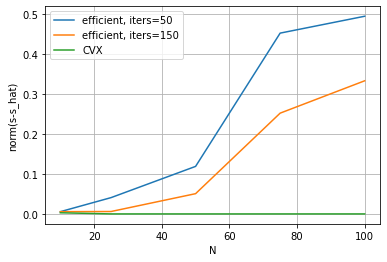

In [9]:
leg = [f'efficient, iters={iters}' for iters in list_iters] + ['CVX']

# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
plt.plot(NN, err.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

### Test hyperparameters and convergence

In [10]:
# Test GAMMAS
NN = [25, 50]  # , 75]
iters = 500
M = 500
p_er = 0.15
noise = 0.05
eps = .1
K = 4
GAMMAS = [.01, .1, .2]
lamb = .1  # .1
beta = 0  # .01 # .01

ss_hat = []
ss = []
for i, N in enumerate(NN):
    print('N:', N)
    _, _, _, _, H, S, Sn, h = MY_utils.gen_data(N, M, p_er, noise, eps, K)

    low_idx = np.concatenate([np.arange(i+1, N)+N*i for i in range(N)])
    s = S.flatten('F')[low_idx]
    norm_S = np.linalg.norm(S, 'fro')
    
    ss.append(s)
    ss_hat.append(np.zeros((len(GAMMAS), iters, s.size)))
    for j, gamma in enumerate(GAMMAS):
        t = time.time()
        S_hat, s_iters = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters, verbose=False)
        t_end = time.time() - t

        err = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        ss_hat[i][j,:,:] = s_iters
        
        print(f'\t- Efficient (iters={iters}): time: {t_end:.3f}s  - err: {err:.3f}')

N: 25
	- Efficient (iters=500): time: 1.133s  - err: 0.017
	- Efficient (iters=500): time: 8.063s  - err: 0.000
	- Efficient (iters=500): time: 11.819s  - err: 0.000
N: 50
	- Efficient (iters=500): time: 57.812s  - err: 0.103
	- Efficient (iters=500): time: 58.006s  - err: 0.103
	- Efficient (iters=500): time: 57.940s  - err: 0.103


<ipython-input-11-ea5d5281d941>:10: RuntimeWarning: invalid value encountered in true_divide
  err = np.linalg.norm(s/norm_s - s_iters[j,k,:]/norm_s_hat)**2


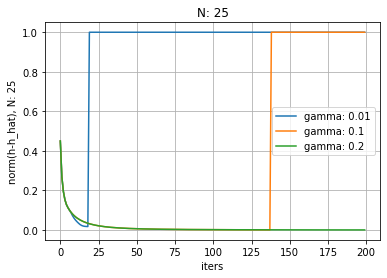

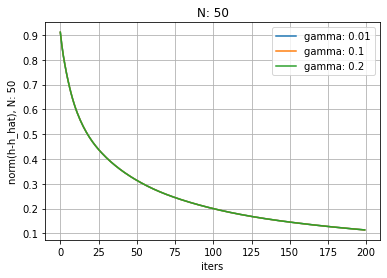

In [11]:
## Compute convergence
err_conv = np.zeros((len(NN), len(GAMMAS), iters-1))
for i in range(len(NN)):
    s = ss[i]
    s_iters = ss_hat[i]
    norm_s = np.linalg.norm(s)
    for j in range(len(GAMMAS)):
        for k in range(iters-1):
            norm_s_hat = np.linalg.norm(s_iters[j,k,:])
            err = np.linalg.norm(s/norm_s - s_iters[j,k,:]/norm_s_hat)**2
            err_conv[i,j,k] = err if err < 1 else 1

leg = []
for N in NN:
    for gamma in GAMMAS:
        leg.append(f'N: {N}, gamma: {gamma}')

plot_iters = 200
for i, N in enumerate(NN):
    leg = [f'gamma: {gamma}' for gamma in GAMMAS]
    plt.figure()
    plt.plot(err_conv[i,:,:plot_iters].T)
    plt.xlabel('iters')
    plt.ylabel('norm(h-h_hat), N: ' + str(N))
    plt.legend(leg)
    plt.title(f'N: {N}')
    plt.grid()

In [12]:
# Test LAMBDAS
NN = [25, 50]  # , 75]
iters = 500
M = 500
p_er = 0.15
noise = 0.05
eps = .1
K = 4
gamma = .1
LAMBS = [.01, .1, .5]  # .1
beta = 0  # .01 # .01

ss_hat = []
ss = []
sns = []
for i, N in enumerate(NN):
    print('N:', N)
    _, _, _, _, H, S, Sn, h = MY_utils.gen_data(N, M, p_er, noise, eps, K)

    low_idx = np.concatenate([np.arange(i+1, N)+N*i for i in range(N)])
    s = S.flatten('F')[low_idx]
    sn = Sn.flatten('F')[low_idx]
    norm_S = np.linalg.norm(S, 'fro')
    
    ss.append(s)
    sns.append(sn)
    ss_hat.append(np.zeros((len(LAMBS), iters, s.size)))
    for j, lamb in enumerate(LAMBS):
        t = time.time()
        S_hat, s_iters = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters, verbose=False)
        t_end = time.time() - t

        err = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        ss_hat[i][j,:,:] = s_iters
        
        print(f'\t- Efficient (iters={iters}): time: {t_end:.3f}s  - err: {err:.3f}')

N: 25
	- Efficient (iters=500): time: 13.122s  - err: 0.021
	- Efficient (iters=500): time: 13.125s  - err: 0.021
	- Efficient (iters=500): time: 13.157s  - err: 0.021
N: 50
	- Efficient (iters=500): time: 60.347s  - err: 0.025
	- Efficient (iters=500): time: 59.721s  - err: 0.025
	- Efficient (iters=500): time: 28.083s  - err: 0.053


N: 50 - err(s,sn) = 0.5286
N: 50 - err(s,sn) = 0.5799


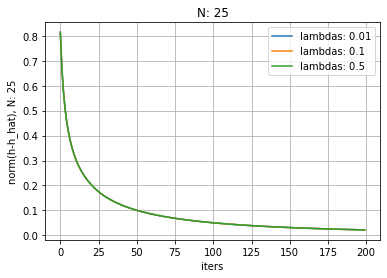

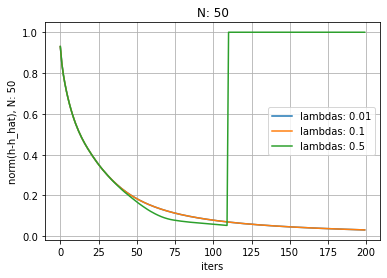

In [13]:
## Compute convergence
err_conv = np.zeros((len(NN), len(LAMBS), iters-1))
for i in range(len(NN)):
    s = ss[i]
    sn = sns[i]
    s_iters = ss_hat[i]
    norm_s = np.linalg.norm(s)
    norm_sn = np.linalg.norm(sn)

    err = np.linalg.norm(s/norm_s - sn/norm_sn)**2
    print(f'N: {N} - err(s,sn) = {err:.4f}')

    for j in range(len(LAMBS)):
        for k in range(iters-1):
            norm_s_hat = np.linalg.norm(s_iters[j,k,:])
            norm_s_hat = 1 if norm_s_hat == 0 else norm_s_hat
            err = np.linalg.norm(s/norm_s - s_iters[j,k,:]/norm_s_hat)**2
            err_conv[i,j,k] = err if err < 1 else 1

leg = []
for N in NN:
    for lamb in LAMBS:
        leg.append(f'N: {N}, lambda: {lamb}')

plot_iters = 200
for i, N in enumerate(NN):
    leg = [f'lambdas: {lamb}' for lamb in LAMBS]
    plt.figure()
    plt.plot(err_conv[i,:,:plot_iters].T)
    plt.xlabel('iters')
    plt.ylabel('norm(h-h_hat), N: ' + str(N))
    plt.legend(leg)
    plt.title(f'N: {N}')
    plt.grid()

## Check efficient algorithm

In [14]:
NN = [10, 25, 50, 75, 100]
M = 500
p_er = 0.15
noise = 0.01
eps = .1
K = 4
mu = .01
lamb = .1
gamma = .1
beta = 0
inc_gamma = 1
delta = 0

regs = (lamb, gamma, beta, inc_gamma, mu)
params = (lamb, gamma, delta, inc_gamma)

iters_out = 50
iters_filters = 100
iters_graph = 100

times = np.zeros((2, len(NN)))
err_H = np.zeros((2, len(NN)))
err_S = np.zeros((2, len(NN)))
for i, N in enumerate(NN):
    print('N:', N)
    X, Y, _, _, H, S, Sn, _ = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    norm_H = np.linalg.norm(H, 'fro')
    norm_S = np.linalg.norm(S, 'fro')

    # Efficient algorithms
    t = time.time()
    H_hat, S_hat, Hs_hat, Ss_hat = opt.efficient_rfi(X, Y, Sn, regs, iters_out, iters_filters, iters_graph, eps=1e-6)
    times[0,i] = time.time() - t

    err_H[0,i] = np.linalg.norm(H_hat - H, 'fro')**2/norm_H**2
    err_Hb = np.linalg.norm(H_hat/np.linalg.norm(H_hat, 'fro') - H/norm_H, 'fro')**2
    err_S[0,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
    err_Sb = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2

    print(f'\t- Efficient: time: {times[0,i]:.3f}s  - Err H: {err_H[0,i]:.3f} ({err_Hb:.3f})', end='')
    print(f' - Err S: {err_S[0,i]:.3f} ({err_Sb:.3f})')

    # CVX algorithm
    t = time.time()
    H_cvx, S_cvx, diff_H, diff_S = opt.rfi(X, Y, Sn, np.eye(N), params, max_iters=iters_out)
    times[-1, i] = time.time() - t
    
    err_H[-1,i] = np.linalg.norm(H_cvx - H, 'fro')/norm_H
    err_Hb = np.linalg.norm(H_cvx/np.linalg.norm(H_cvx, 'fro') - H/norm_H, 'fro')**2
    err_S[-1,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx, 'fro') - S/norm_S, 'fro')**2
    err_Sb = np.linalg.norm(S_cvx - S, 'fro')/norm_S
    
    print(f'\t- CVX: time: {times[-1,i]:.3f}s  - Err H: {err_H[-1,i]:.3f} ({err_Hb:.3f})', end='')
    print(f' - Err S: {err_S[-1,i]:.3f} ({err_Sb:.3f})')

N: 10
Convergence reached at iteration 3
	- Efficient: time: 0.535s  - Err H: 0.000 (0.000) - Err S: 0.002 (0.585)
Convergence reached at iteration 1
	- CVX: time: 0.051s  - Err H: 0.014 (0.000) - Err S: 0.000 (0.021)
N: 25
Convergence reached at iteration 4
	- Efficient: time: 14.422s  - Err H: 0.000 (0.000) - Err S: 0.012 (0.808)
Convergence reached at iteration 2
	- CVX: time: 1.437s  - Err H: 0.021 (0.000) - Err S: 0.003 (0.055)
N: 50
Convergence reached at iteration 27
	- Efficient: time: 400.469s  - Err H: 0.001 (0.001) - Err S: 0.204 (0.903)
Convergence reached at iteration 4
	- CVX: time: 113.397s  - Err H: 0.033 (0.001) - Err S: 0.005 (0.415)
N: 75
Convergence reached at iteration 29
	- Efficient: time: 1764.600s  - Err H: 0.002 (0.002) - Err S: 1.680 (0.990)
Convergence reached at iteration 2
	- CVX: time: 903.439s  - Err H: 0.043 (0.002) - Err S: 0.016 (0.989)
N: 100
Convergence reached at iteration 37
	- Efficient: time: 4049.178s  - Err H: 0.002 (0.002) - Err S: 1.778 (0.9

Text(0, 0.5, 'norm(s-s_hat)')

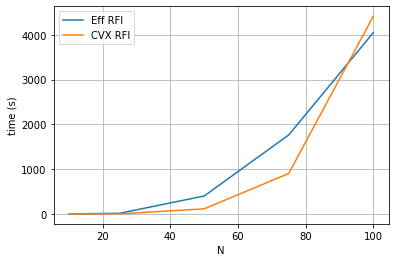

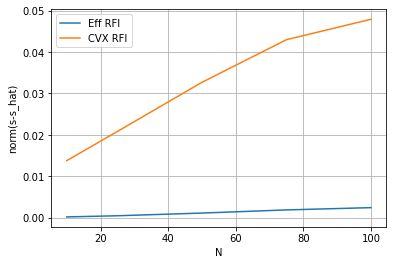

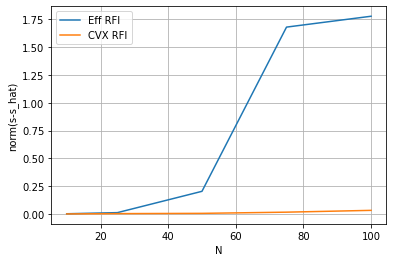

In [15]:
# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
plt.plot(NN, err_H.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

plt.figure()
plt.plot(NN, err_S.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

## Experiment 1 - Test efficient algorithm and individual steps

In [2]:
# Experiment parameters
n_graphs = 50
models = ['H-cf', 'H-eff', 'S-CVX', 'S-eff', 'RFI-stand', 'RFI-eff']
fmts = ['--v', '-v', '--+', '-+', '--o', '-o']
n_models = len(models)

NN =  [10, 25, 50, 75, 100]
M = 500
p_er = 0.15
noise = 0.01
eps = .1
K = 4
mu = .01
lamb = .1
gamma = .1
beta = 0
inc_gamma = 1
delta = 0

regs = (lamb, gamma, beta, inc_gamma, mu)
params = (lamb, gamma, delta, inc_gamma)

iters_out = 5
iters_in = 150

In [3]:
# test_eff_steps
def test_steps(i, NN, M, p, noise, eps, K, regs, params, iters_out, iters_in):
    print(f'- Graph {i}')
    lamb, gamma, beta, inc_gamma, mu = regs
    
    times = np.zeros((n_models, len(NN)))
    err = np.zeros((n_models, len(NN)))
    for i, N in enumerate(NN):
        X, Y, _, _, H, S, Sn, _ = MY_utils.gen_data(N, M, p, noise, eps, K)
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')
        norm_H = np.linalg.norm(H, 'fro')
        norm_S = np.linalg.norm(S, 'fro')

        # Filter step: closed form
        t = time.time()
        X_kron = np.kron(XX, np.eye(N))
        Z = np.kron(S@S, np.eye(N)) + np.kron(np.eye(N), S@S) - 2*np.kron(S, S)
        H_cf = (np.linalg.inv(X_kron + gamma*Z)@y_kron).reshape((N,N), order='F')
        times[0,i] = time.time() - t
        err[0,i] = (np.linalg.norm(H_cf - H, 'fro')/norm_H)**2

        # Filter step: efficient
        t = time.time()
        H_filt, _ = opt.efficient_filter_id(XX, S, y_kron, gamma, mu, max_iters=iters_in)
        times[1,i] = time.time() - t
        err[1,i] = (np.linalg.norm(H_filt - H, 'fro')/norm_H)**2

        # Graph step: CVX
        t = time.time()
        S_cvx = opt.graph_id(Sn, H, np.eye(N), lamb, gamma, delta=0)
        times[2, i] = time.time() - t
        err[2,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2

        # Graph step: efficient
        t = time.time()
        S_hat, _ = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters_in)
        times[3,i] = time.time() - t
        err[3,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2

        # RFI: standard
        t = time.time()
        H_cvx, S_cvx, diff_H, diff_S = opt.rfi(X, Y, Sn, np.eye(N), params, max_iters=iters_out, th=0)
        times[4, i] = time.time() - t

        # RFI: efficient
        t = time.time()
        H_rfi, S_rfi, _, _ = opt.efficient_rfi(X, Y, Sn, regs, iters_out, iters_in, iters_in, eps=0)
        times[5,i] = time.time() - t
    
    return times, err


In [4]:

print('N_CPUS:', N_CPUS)

times = np.zeros((n_graphs, n_models, len(NN)))
err = np.zeros((n_graphs, n_models, len(NN)))

total_t = time.time()

pool = Parallel(n_jobs=N_CPUS)
resps = pool(delayed(test_steps)(i, NN, M, p_er, noise, eps, K, regs, params, iters_out, iters_in) for i in range(n_graphs))
for i, resp in enumerate(resps):
    times[i,:,:], err[i,:,:] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')



N_CPUS: 12
----- 0.6869539459546407  mins -----


Text(0, 0.5, 'error')

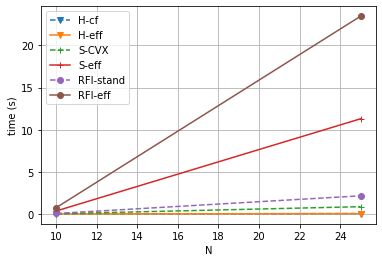

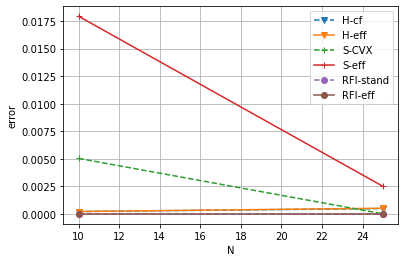

In [7]:
mean_times = times.mean(axis=0)
mean_err = err.mean(axis=0)

# Plot time
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_times[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_err[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('error')